# Polymer Systems

In [3]:
using Clapeyron
import PyPlot; const plt = PyPlot

PyPlot

## Gas solubility
Let us first consider an important property when considering polymer systems: solubility of light gases. In the first instance, let us construct the model. 

The real challenge when it comes to polymers isn't really the calculations. It is the model construction. Most polymer parameters are expressed in terms of the molecular weight of the polymer:

| Polymer | ϵ (K) | σ (Å) | m per Mw |
|---------|-----------------------------------------|----------------|-----------------|
| PS      | 348.20                                  | 4.152          | 0.0205          |
| PBD     | 288.84                                  | 4.097          | 0.0245          |
| PMMA    | 264.60                                  | 3.553          | 0.0270          |

As such, the model needs to be constructed manually.

We will consider the case of the solubility of carbon dioxide in polybutadiene:

In [10]:
Mw = 1000.

polymer_param = ParamTable(:like,(
                species = ["PS"],
                Mw = [Mw],
                epsilon = [348.20],
                sigma = [4.152],
                segment = [0.0205*Mw],
                n_H = [0],
                n_e = [0]))

model = PCSAFT(["carbon dioxide","PS"]; userlocations=[polymer_param]);

When we discuss the solubility of a light gas in polymer, what we are really talking about is equilibrium between vapor and liquid phase. This is just a bubble point!

Unfortunately, this type of calculation can be quite challenging as the polymer will usually be present in the vapor phase in _very_ low concentrations. A nice trick is to simply treat the polymer as non-volatile. This can be done by specifying this in our method:

In [14]:
method = FugBubblePressure(nonvolatiles=["PS"]);

We can then solve for the bubble point:

In [17]:
T = 298.15
x = [0.001, 0.999]

(p, vl, vv, y) = bubble_pressure(model, T, x, method)

(953.3656403574464, 0.0009402248232084722, 2.600091016602562, [1.0, 0.0])

We can now trace the solubility of carbon dioxide in PS for a range of pressures. Typically, the solubility is expressed using mass fractions, whereas the `bubble_pressure` functiont takes mole fractions. We provide converters through `Clapeyron.mass_to_mole(model, x)`:

In [41]:
w = LinRange(0.,0.2, 100)
p = zeros(length(w))
for i in 2:length(w)
    x = Clapeyron.mole_to_mass(model,[w[i],1-w[i]]) 
    p[i] = bubble_pressure(model, T, x, method)[1]
end

Plotting:

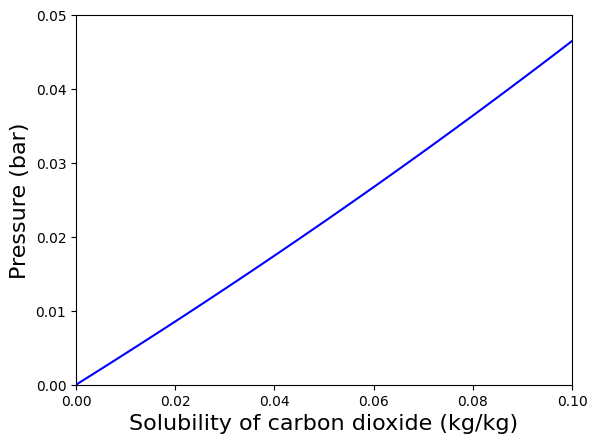

In [42]:
plt.clf()
fig, ax = plt.subplots()
ax.plot(w, p ./ 1e5, color="blue")
ax.set_xlabel("Solubility of carbon dioxide (kg/kg)", fontsize=16)
ax.set_ylabel("Pressure (bar)", fontsize=16)
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.05);
# ax.set_xticks(fontsize=14)
# ax.set_yticks(fontsize=14);

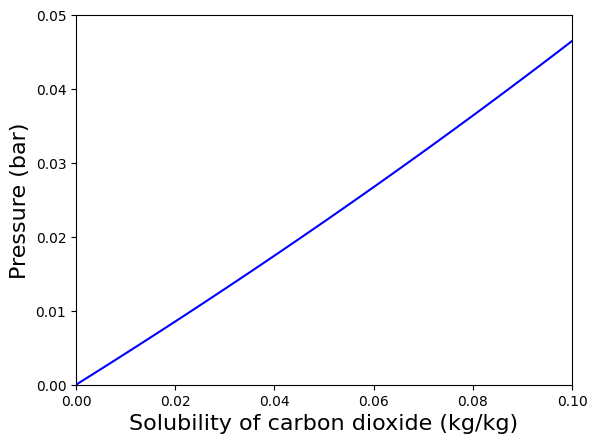

In [43]:
display(fig)

## Polymer Blend immiscibility

## Custom Models